# Intestinal organoid differentiation - Fate mapping

Fate analysis using velocities derived from metabolic labeling.

## Library imports

In [54]:
import os
import sys

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

import cellrank as cr
import scanpy as sc
import scvelo as scv

from cr2 import (
    get_state_purity,
    get_var_ranks,
    plot_state_purity,
    plot_states,
    running_in_notebook,
)

sys.path.extend(["../../", "."])
from paths import DATA_DIR, FIG_DIR  # isort: skip  # noqa: E402

## General settings

In [55]:
sc.settings.verbosity = 3
scv.settings.verbosity = 3
cr.settings.verbosity = 2

In [56]:
scv.settings.set_figure_params("scvelo")

In [57]:
SAVE_FIGURES = False

if SAVE_FIGURES:
    os.makedirs(FIG_DIR / "labeling_kernel", exist_ok=True)

## Data loading

In [58]:
adata = sc.read(DATA_DIR / "sceu_organoid" / "processed" / "preprocessed.h5ad")
adata

AnnData object with n_obs × n_vars = 3452 × 2000
    obs: 'experiment', 'labeling_time', 'cell_type', 'som_cluster_id', 'cell_type_merged', 'initial_size', 'n_counts'
    var: 'ensum_id', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'cell_type_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_umap_paper'
    varm: 'PCs'
    layers: 'labeled', 'total', 'unlabeled'
    obsp: 'connectivities', 'distances'

In [59]:
pd.DataFrame(adata.obs[["labeling_time", "experiment"]].groupby("experiment").apply(lambda x: x.value_counts())).rename(
    {0: "value_counts"}, axis=1
).droplevel(level=2).sort_index()

value_counts
experiment labeling_time              
Chase      0.00                    647
           0.75                    805
           6.00                    632
Pulse      2.00                   1368

## Data preprocessing

In [60]:
adata.layers["labeled_smoothed"] = csr_matrix.dot(adata.obsp["connectivities"], adata.layers["labeled"]).A
adata.layers["unlabeled_smoothed"] = csr_matrix.dot(adata.obsp["connectivities"], adata.layers["unlabeled"]).A
adata.layers["total_smoothed"] = csr_matrix.dot(adata.obsp["connectivities"], adata.layers["total"]).A

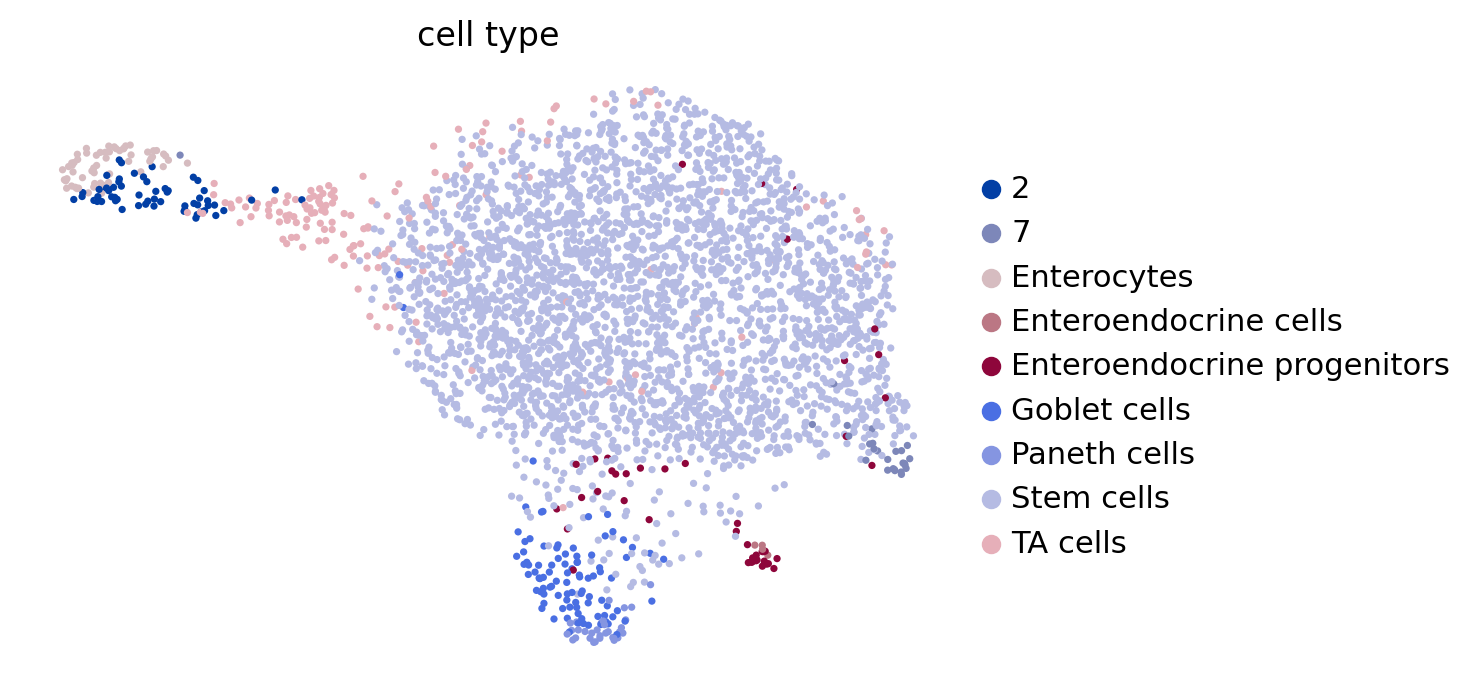

In [61]:
if running_in_notebook():
    scv.pl.scatter(adata, basis="umap", color="cell_type", legend_loc="right")

## Parameter inference

In [62]:
alpha = pd.read_csv(DATA_DIR / "sceu_organoid" / "results" / "alpha.csv", index_col=0)
alpha.index = alpha.index.astype(str)
adata.layers["transcription_rate"] = alpha.loc[adata.obs_names, adata.var_names]

gamma = pd.read_csv(DATA_DIR / "sceu_organoid" / "results" / "gamma.csv", index_col=0)
gamma.index = gamma.index.astype(str)
adata.layers["degradation_rate"] = gamma.loc[adata.obs_names, adata.var_names]

r0 = pd.read_csv(DATA_DIR / "sceu_organoid" / "results" / "r0.csv", index_col=0)
r0.index = r0.index.astype(str)
adata.layers["r0"] = r0.loc[adata.obs_names, adata.var_names]

success = pd.read_csv(DATA_DIR / "sceu_organoid" / "results" / "success.csv", index_col=0)

## Velocity

In [63]:
adata.layers["velocity_labeled"] = (alpha - gamma * adata.layers["labeled_smoothed"]).values

## CellRank

In [64]:
vk = cr.kernels.VelocityKernel(adata, xkey="labeled_smoothed", vkey="velocity_labeled").compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()

combined_kernel = 0.8 * vk + 0.2 * ck

Computing transition matrix using `'deterministic'` model


  0%|          | 0/3452 [00:00<?, ?cell/s]

Using `softmax_scale=2.4573`


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: 

  0%|          | 0/3452 [00:00<?, ?cell/s]

    Finish (0:00:04)
Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


### Estimator analysis

In [65]:
estimator = cr.estimators.GPCCA(combined_kernel)

Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)


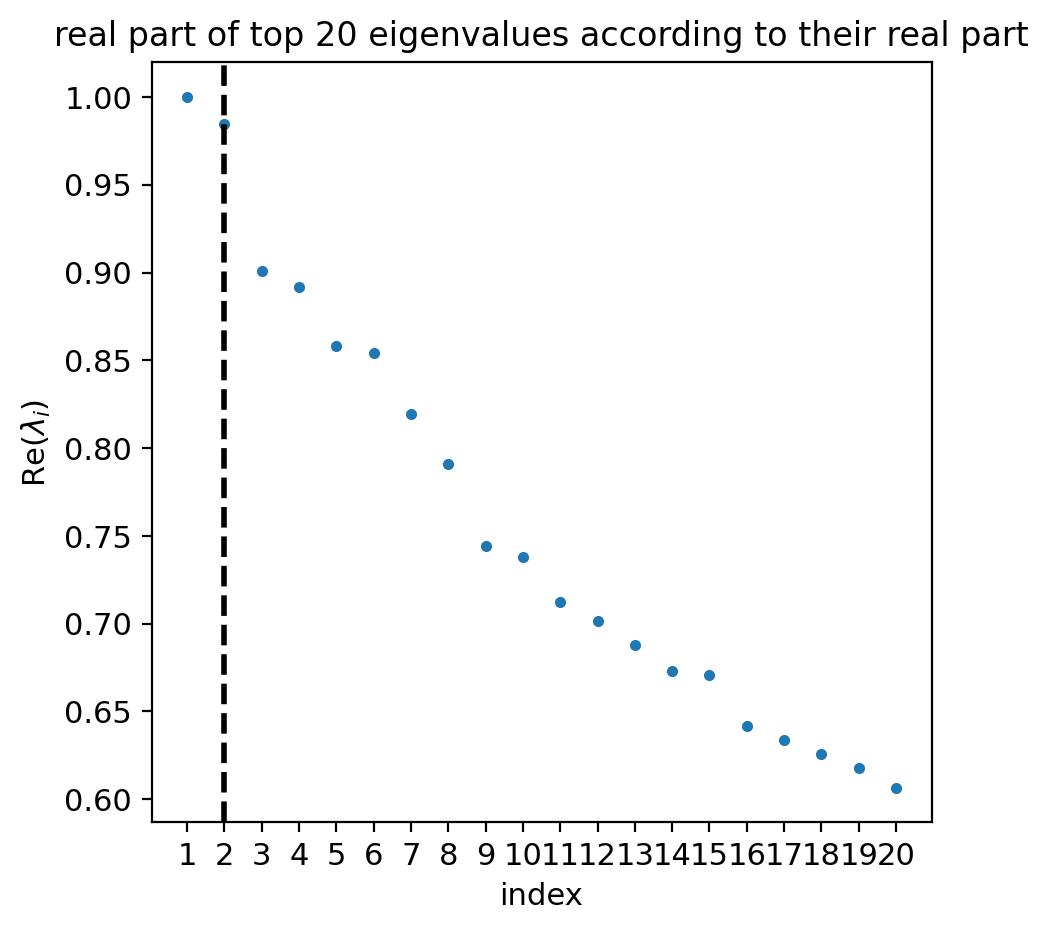

In [66]:
estimator.compute_schur(n_components=20)
if running_in_notebook():
    estimator.plot_spectrum(real_only=True)

#### Macrostates

In [67]:
estimator.compute_macrostates(n_states=12, cluster_key="cell_type")

Computing `12` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:06)


GPCCA[kernel=(0.8 * VelocityKernel[n=3452] + 0.2 * ConnectivityKernel[n=3452]), initial_states=None, terminal_states=None]

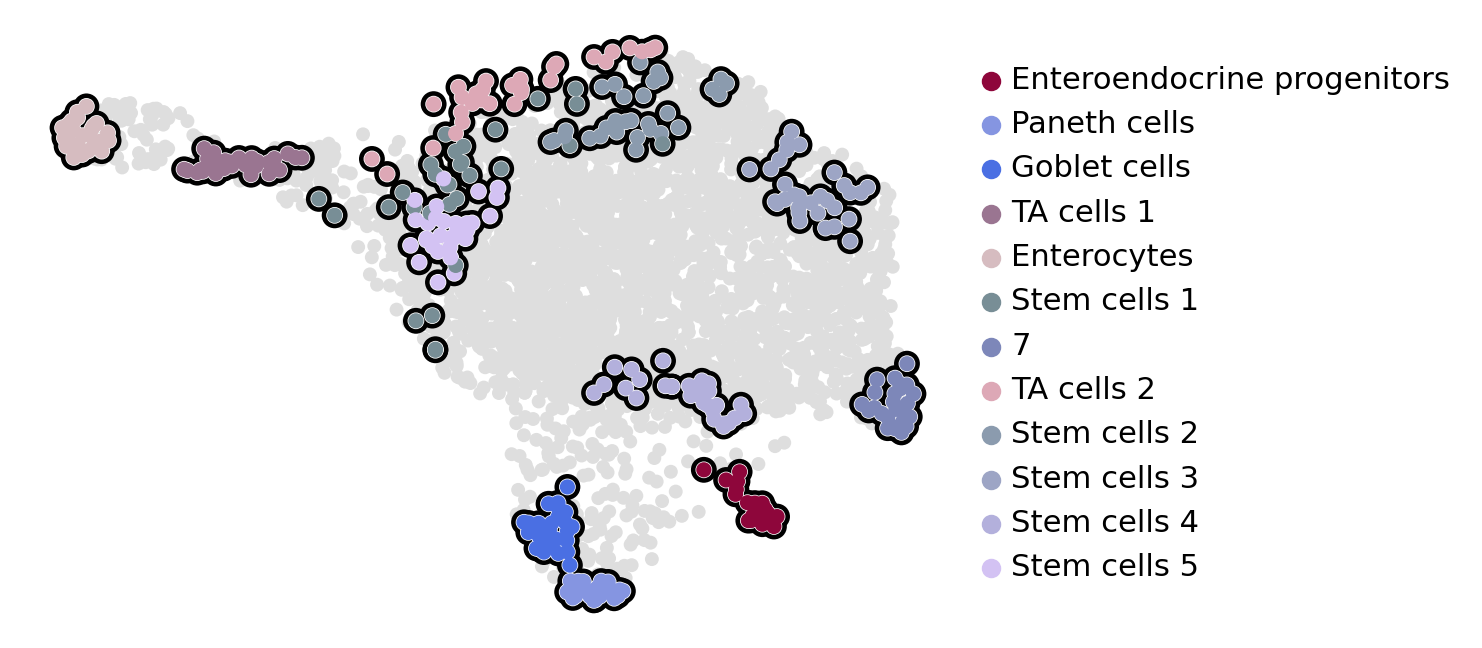

In [68]:
if running_in_notebook():
    plot_states(
        adata,
        estimator=estimator,
        which="macrostates",
        basis="umap",
        legend_loc="right",
        title="",
        size=100,
    )

    if SAVE_FIGURES:
        fpath = FIG_DIR / "labeling_kernel" / "umap_colored_by_cr_macrostates.pdf"
        plot_states(
            adata,
            estimator=estimator,
            which="macrostates",
            basis="umap",
            legend_loc=False,
            title="",
            size=100,
            fpath=fpath,
            format="pdf",
        )

Mean purity: 0.8222222222222223


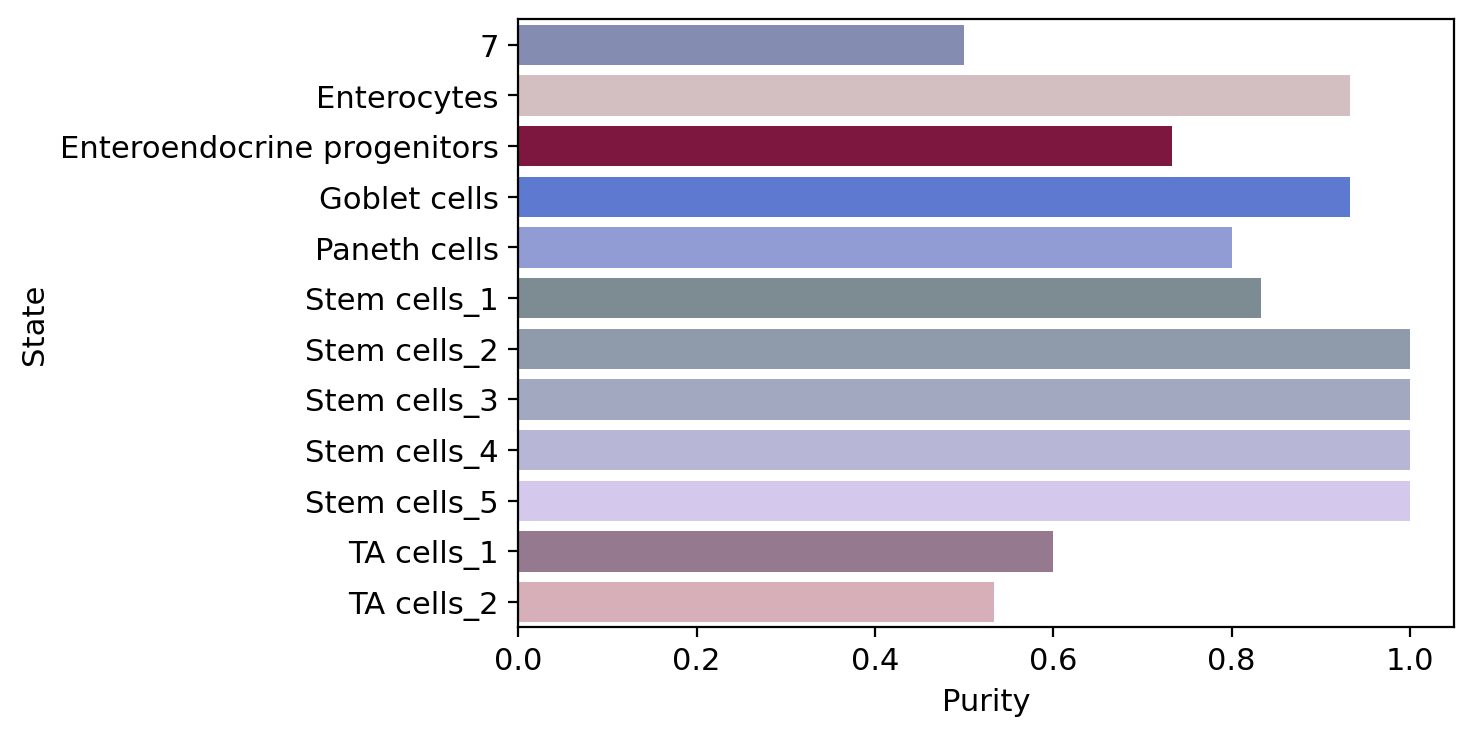

In [69]:
macrostate_purity = get_state_purity(adata, estimator, states="macrostates", obs_col="cell_type")
print(f"Mean purity: {np.mean(list(macrostate_purity.values()))}")

if running_in_notebook():
    if SAVE_FIGURES:
        fpath = FIG_DIR / "labeling_kernel" / "macrostate_purity_labeling_velo.pdf"
    else:
        fpath = None

    palette = dict(zip(estimator.macrostates.cat.categories, estimator._macrostates.colors))
    order = estimator.macrostates.cat.categories.sort_values().to_list()
    plot_state_purity(macrostate_purity, palette=palette, order=order, fpath=fpath, format="eps")

In [70]:
estimator.set_terminal_states(states=["Enterocytes", "Paneth cells", "Enteroendocrine progenitors", "Goblet cells"])
terminal_states = estimator.terminal_states.cat.categories

pd.DataFrame(adata.obs["term_states_fwd"]).rename(columns={"term_states_fwd": "terminal_state"}).to_csv(
    DATA_DIR / "sceu_organoid" / "results" / "cr_terminal_states.csv"
)

Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


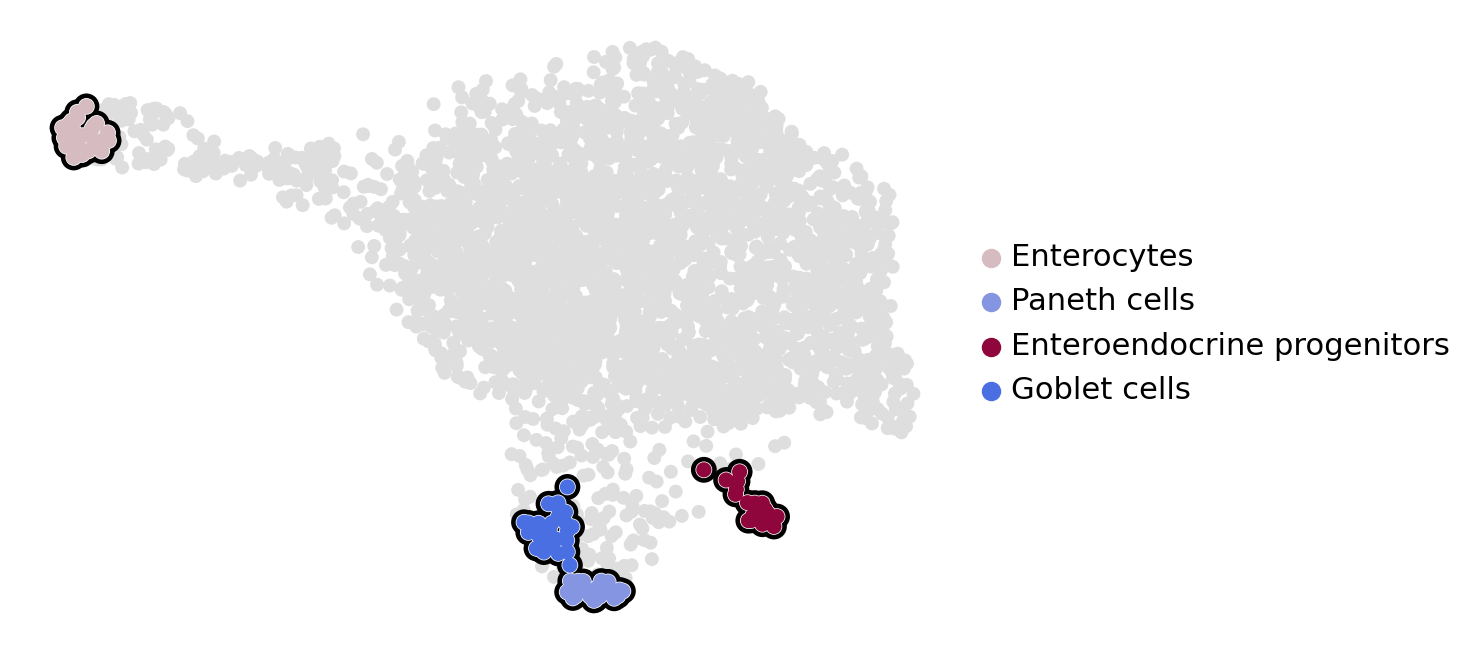

In [71]:
if running_in_notebook():
    plot_states(
        adata,
        estimator=estimator,
        which="terminal_states",
        basis="umap",
        legend_loc="right",
        title="",
        size=100,
    )

    if SAVE_FIGURES:
        fpath = FIG_DIR / "labeling_kernel" / "umap_colored_by_cr_terminal_states.pdf"
        plot_states(
            adata,
            estimator=estimator,
            which="terminal_states",
            basis="umap",
            legend_loc=False,
            title="",
            size=100,
            fpath=fpath,
            format="pdf",
        )

Mean purity: 0.8500000000000001


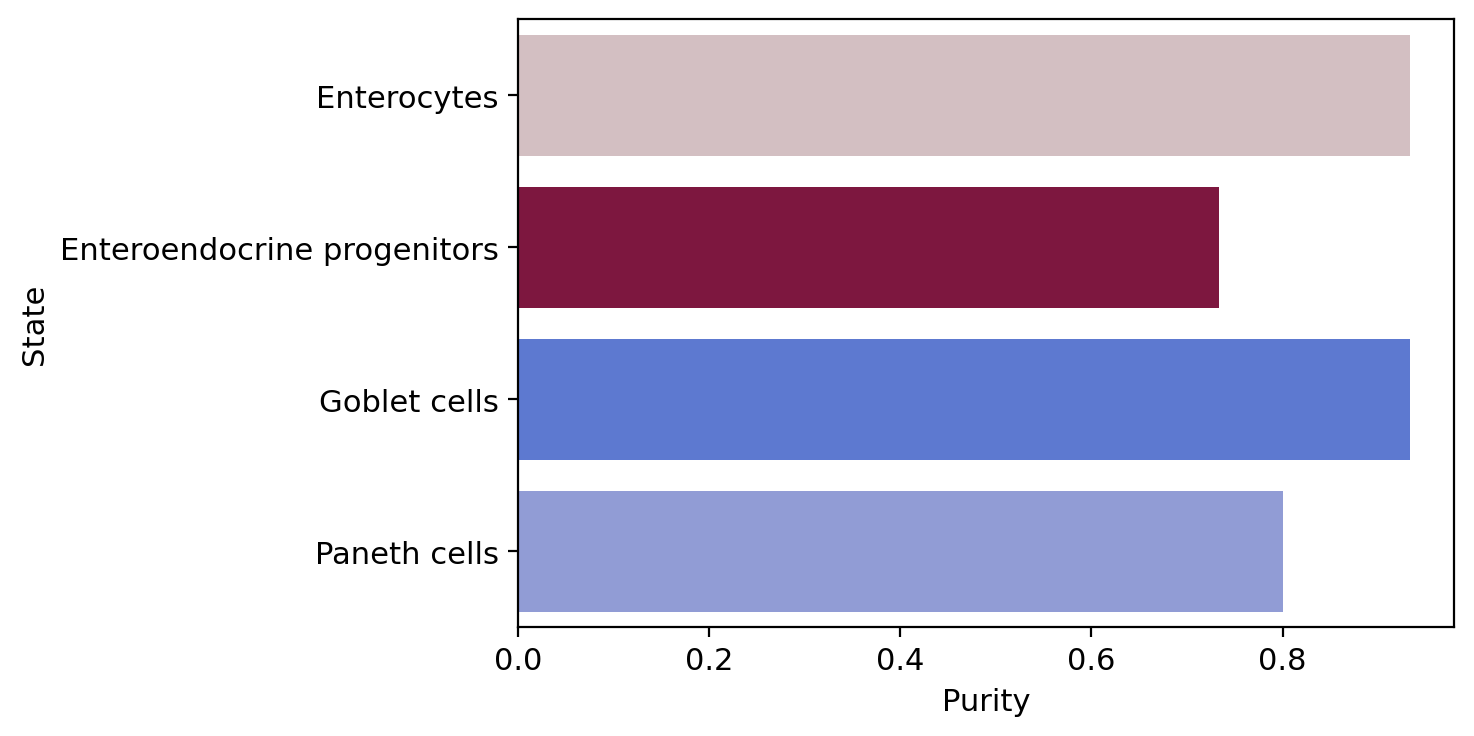

In [72]:
terminal_state_purity = get_state_purity(adata, estimator, states="terminal_states", obs_col="cell_type")
print(f"Mean purity: {np.mean(list(terminal_state_purity.values()))}")

if running_in_notebook():
    if SAVE_FIGURES:
        fpath = FIG_DIR / "labeling_kernel" / "terminal_state_purity_labeling_velo.pdf"
    else:
        fpath = None

    palette = dict(zip(estimator.terminal_states.cat.categories, estimator._term_states.colors))
    order = estimator.terminal_states.cat.categories.sort_values().to_list()
    plot_state_purity(terminal_state_purity, palette=palette, order=order, fpath=fpath, format="eps")

#### Fate probabilities

In [73]:
estimator.compute_fate_probabilities()

Computing absorption probabilities


  0%|          | 0/4 [00:00<?, ?/s]

Adding `adata.obsm['lineages_fwd']`
       `.absorption_probabilities`
    Finish (0:00:00)


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


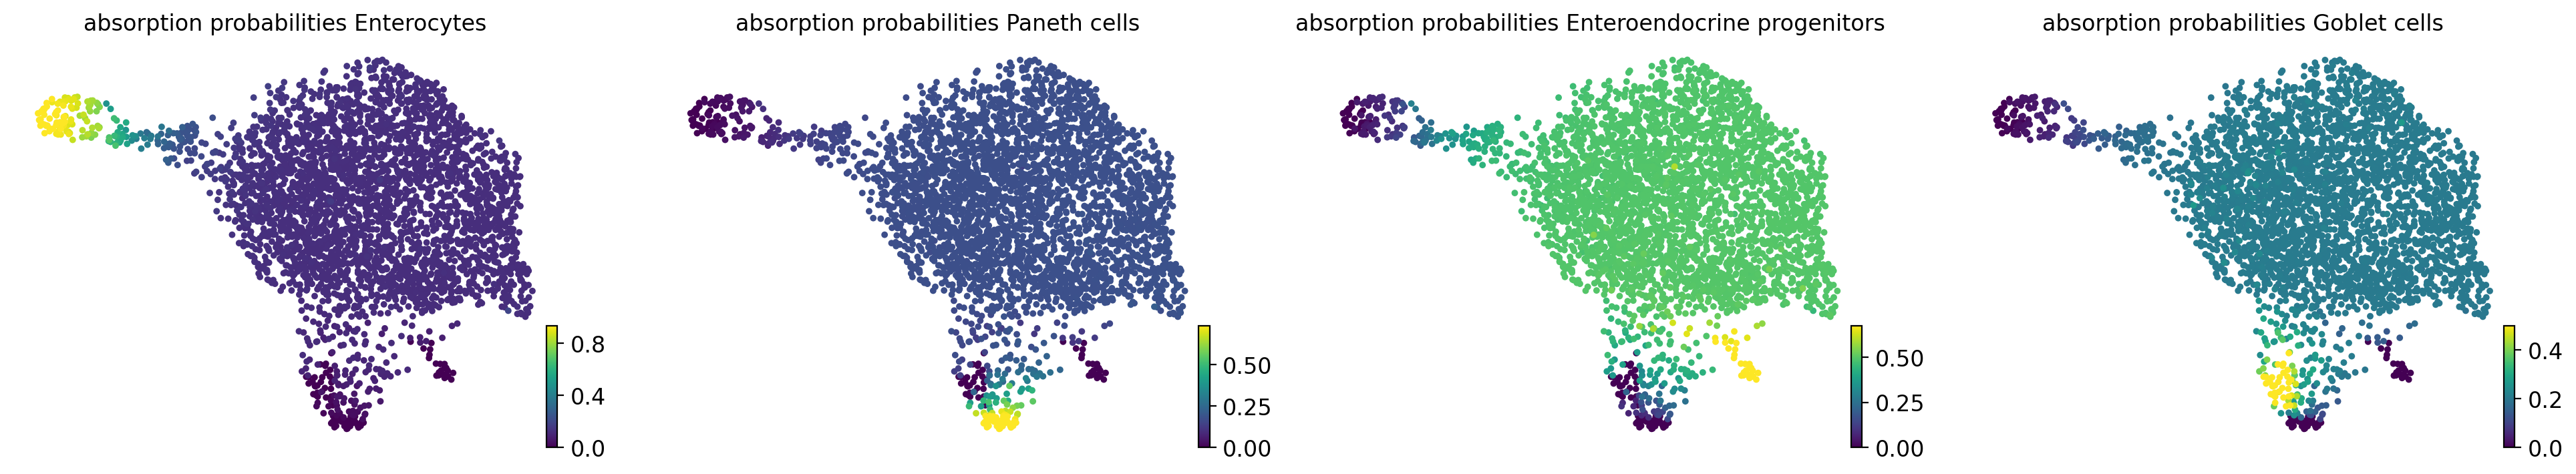

In [74]:
if running_in_notebook():
    estimator.plot_fate_probabilities(same_plot=False, size=50, basis="umap")

### Driver analysis

In [75]:
gene_ranks = {terminal_state: pd.DataFrame() for terminal_state in terminal_states}
gene_ranks_gex = {terminal_state: pd.DataFrame() for terminal_state in terminal_states}

In [76]:
drivers = {}
for terminal_state in terminal_states:
    drivers[terminal_state] = estimator.compute_lineage_drivers(
        layer="transcription_rate",
        cluster_key="cell_type",
        lineages=[terminal_state],
        clusters=["Stem cells", terminal_state],
        return_drivers=True,
    )
    drivers[terminal_state] = drivers[terminal_state].merge(
        pd.DataFrame(drivers[terminal_state].sort_values(by=f"{terminal_state}_corr", ascending=False).index)
        .reset_index()
        .rename({"index": f"Corr. rank - {terminal_state}", 0: "Gene"}, axis=1)
        .set_index("Gene"),
        left_index=True,
        right_index=True,
    )

drivers = pd.concat(drivers.values(), axis=1)

Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)
Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)
Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)
Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)


In [77]:
drivers_gex = {}
for terminal_state in terminal_states:
    drivers_gex[terminal_state] = estimator.compute_lineage_drivers(
        layer="labeled_smoothed",
        cluster_key="cell_type",
        lineages=[terminal_state],
        clusters=["Stem cells", terminal_state],
        return_drivers=True,
    )
    drivers_gex[terminal_state] = drivers_gex[terminal_state].merge(
        pd.DataFrame(drivers_gex[terminal_state].sort_values(by=f"{terminal_state}_corr", ascending=False).index)
        .reset_index()
        .rename({"index": f"Corr. rank - {terminal_state}", 0: "Gene"}, axis=1)
        .set_index("Gene"),
        left_index=True,
        right_index=True,
    )

drivers_gex = pd.concat(drivers_gex.values(), axis=1)

Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)
Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)
Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)
Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)


#### Driver analysis - Goblet

In [78]:
goblet_markers = (
    pd.read_csv(DATA_DIR / "sceu_organoid" / "processed" / "goblet_markers.csv")["Gene"].str.lower().tolist()
)

goblet_markers = adata.var_names[adata.var_names.str.lower().isin(goblet_markers)]

In [79]:
goblet_regulators = (
    pd.read_csv(DATA_DIR / "sceu_organoid" / "processed" / "goblet_regulators.csv")["Gene"].str.lower().tolist()
)

goblet_regulators = adata.var_names[adata.var_names.str.lower().isin(goblet_regulators)]

In [80]:
goblet_and_paneth_regulators = (
    pd.read_csv(DATA_DIR / "sceu_organoid" / "processed" / "goblet_and_paneth_regulators.csv")["Gene"]
    .str.lower()
    .tolist()
)

goblet_and_paneth_regulators = adata.var_names[adata.var_names.str.lower().isin(goblet_and_paneth_regulators)]

In [81]:
_df = get_var_ranks(
    var_names=goblet_markers, drivers=drivers, macrostate="Goblet cells", var_type="Marker", model="CR2"
)
gene_ranks["Goblet cells"] = pd.concat([gene_ranks["Goblet cells"], _df])

Marker towards Goblet cells for CR2 in top 100: 23 (out of 85)


In [82]:
_df = get_var_ranks(
    var_names=goblet_markers, drivers=drivers_gex, macrostate="Goblet cells", var_type="Marker", model="CR2 - GEX"
)
gene_ranks_gex["Goblet cells"] = pd.concat([gene_ranks_gex["Goblet cells"], _df])

Marker towards Goblet cells for CR2 - GEX in top 100: 33 (out of 85)


In [83]:
_df = get_var_ranks(
    var_names=goblet_regulators,
    drivers=drivers,
    macrostate="Goblet cells",
    var_type="Goblet regulator",
    model="CR2",
)
gene_ranks["Goblet cells"] = pd.concat([gene_ranks["Goblet cells"], _df])

Goblet regulator towards Goblet cells for CR2 in top 100: 2 (out of 8)


In [84]:
_df = get_var_ranks(
    var_names=goblet_regulators,
    drivers=drivers_gex,
    macrostate="Goblet cells",
    var_type="Goblet regulator",
    model="CR2 - GEX",
)
gene_ranks_gex["Goblet cells"] = pd.concat([gene_ranks_gex["Goblet cells"], _df])

Goblet regulator towards Goblet cells for CR2 - GEX in top 100: 1 (out of 8)


In [85]:
_df = get_var_ranks(
    var_names=goblet_and_paneth_regulators,
    drivers=drivers,
    macrostate="Goblet cells",
    var_type="Goblet/Paneth regulator",
    model="CR2",
)
gene_ranks["Goblet cells"] = pd.concat([gene_ranks["Goblet cells"], _df])

Goblet/Paneth regulator towards Goblet cells for CR2 in top 100: 2 (out of 5)


In [86]:
_df = get_var_ranks(
    var_names=goblet_and_paneth_regulators,
    drivers=drivers_gex,
    macrostate="Goblet cells",
    var_type="Goblet/Paneth regulator",
    model="CR2 - GEX",
)
gene_ranks_gex["Goblet cells"] = pd.concat([gene_ranks_gex["Goblet cells"], _df])

Goblet/Paneth regulator towards Goblet cells for CR2 - GEX in top 100: 0 (out of 5)


#### Driver analysis - Paneth

In [87]:
paneth_markers = (
    pd.read_csv(DATA_DIR / "sceu_organoid" / "processed" / "paneth_markers.csv")["Gene"].str.lower().tolist()
)

paneth_markers = adata.var_names[adata.var_names.str.lower().isin(paneth_markers)]

In [88]:
_df = get_var_ranks(
    var_names=paneth_markers, drivers=drivers, macrostate="Paneth cells", var_type="Marker", model="CR2"
)
gene_ranks["Paneth cells"] = pd.concat([gene_ranks["Paneth cells"], _df])

Marker towards Paneth cells for CR2 in top 100: 10 (out of 18)


In [89]:
_df = get_var_ranks(
    var_names=paneth_markers, drivers=drivers_gex, macrostate="Paneth cells", var_type="Marker", model="CR2 - GEX"
)
gene_ranks_gex["Paneth cells"] = pd.concat([gene_ranks_gex["Paneth cells"], _df])

Marker towards Paneth cells for CR2 - GEX in top 100: 14 (out of 18)


In [90]:
_df = get_var_ranks(
    var_names=goblet_and_paneth_regulators,
    drivers=drivers,
    macrostate="Paneth cells",
    var_type="Goblet/Paneth regulator",
    model="CR2",
)
gene_ranks["Paneth cells"] = pd.concat([gene_ranks["Paneth cells"], _df])

Goblet/Paneth regulator towards Paneth cells for CR2 in top 100: 1 (out of 5)


In [91]:
_df = get_var_ranks(
    var_names=goblet_and_paneth_regulators,
    drivers=drivers_gex,
    macrostate="Paneth cells",
    var_type="Goblet/Paneth regulator",
    model="CR2 - GEX",
)
gene_ranks_gex["Paneth cells"] = pd.concat([gene_ranks_gex["Paneth cells"], _df])

Goblet/Paneth regulator towards Paneth cells for CR2 - GEX in top 100: 0 (out of 5)


#### Driver analysis - Enteroendocrine

In [92]:
eec_markers = pd.read_csv(DATA_DIR / "sceu_organoid" / "processed" / "eec_markers.csv")["Gene"].str.lower().tolist()

eec_markers = adata.var_names[adata.var_names.str.lower().isin(eec_markers)]

In [93]:
eec_progenitor_markers = (
    pd.read_csv(DATA_DIR / "sceu_organoid" / "processed" / "eec_progenitor_markers.csv")["Gene"].str.lower().tolist()
)

eec_progenitor_markers = adata.var_names[adata.var_names.str.lower().isin(eec_progenitor_markers)]

In [94]:
_df = get_var_ranks(
    var_names=eec_markers,
    drivers=drivers,
    macrostate="Enteroendocrine progenitors",
    var_type="Marker",
    model="CR2",
)
gene_ranks["Enteroendocrine progenitors"] = pd.concat([gene_ranks["Enteroendocrine progenitors"], _df])

Marker towards Enteroendocrine progenitors for CR2 in top 100: 29 (out of 95)


In [95]:
_df = get_var_ranks(
    var_names=eec_markers,
    drivers=drivers_gex,
    macrostate="Enteroendocrine progenitors",
    var_type="Marker",
    model="CR2 - GEX",
)
gene_ranks_gex["Enteroendocrine progenitors"] = pd.concat([gene_ranks_gex["Enteroendocrine progenitors"], _df])

Marker towards Enteroendocrine progenitors for CR2 - GEX in top 100: 36 (out of 95)


In [96]:
_df = get_var_ranks(
    var_names=eec_progenitor_markers,
    drivers=drivers,
    macrostate="Enteroendocrine progenitors",
    var_type="Progenitor marker",
    model="CR2",
)
gene_ranks["Enteroendocrine progenitors"] = pd.concat([gene_ranks["Enteroendocrine progenitors"], _df])

Progenitor marker towards Enteroendocrine progenitors for CR2 in top 100: 10 (out of 67)


In [97]:
_df = get_var_ranks(
    var_names=eec_progenitor_markers,
    drivers=drivers_gex,
    macrostate="Enteroendocrine progenitors",
    var_type="Progenitor marker",
    model="CR2 - GEX",
)
gene_ranks_gex["Enteroendocrine progenitors"] = pd.concat([gene_ranks_gex["Enteroendocrine progenitors"], _df])

Progenitor marker towards Enteroendocrine progenitors for CR2 - GEX in top 100: 10 (out of 67)


#### Driver analysis - Enterocytes

In [98]:
enterocyte_markers = (
    pd.read_csv(DATA_DIR / "sceu_organoid" / "processed" / "enterocyte_markers.csv")["Gene"].str.lower().tolist()
)

enterocyte_markers = adata.var_names[adata.var_names.str.lower().isin(enterocyte_markers)]

In [99]:
enterocyte_progenitor_markers = (
    pd.read_csv(DATA_DIR / "sceu_organoid" / "processed" / "enterocyte_progenitor_markers.csv")["Gene"]
    .str.lower()
    .tolist()
)

enterocyte_progenitor_markers = adata.var_names[adata.var_names.str.lower().isin(enterocyte_progenitor_markers)]

In [100]:
_df = get_var_ranks(
    var_names=enterocyte_markers, drivers=drivers, macrostate="Enterocytes", var_type="Marker", model="CR2"
)
gene_ranks["Enterocytes"] = pd.concat([gene_ranks["Enterocytes"], _df])

Marker towards Enterocytes for CR2 in top 100: 68 (out of 171)


In [101]:
_df = get_var_ranks(
    var_names=enterocyte_markers, drivers=drivers_gex, macrostate="Enterocytes", var_type="Marker", model="CR2 - GEX"
)
gene_ranks_gex["Enterocytes"] = pd.concat([gene_ranks_gex["Enterocytes"], _df])

Marker towards Enterocytes for CR2 - GEX in top 100: 74 (out of 171)


In [102]:
_df = get_var_ranks(
    var_names=enterocyte_progenitor_markers,
    drivers=drivers,
    macrostate="Enterocytes",
    var_type="Progenitor marker",
    model="CR2",
)
gene_ranks["Enterocytes"] = pd.concat([gene_ranks["Enterocytes"], _df])

Progenitor marker towards Enterocytes for CR2 in top 100: 0 (out of 11)


In [103]:
_df = get_var_ranks(
    var_names=enterocyte_progenitor_markers,
    drivers=drivers_gex,
    macrostate="Enterocytes",
    var_type="Progenitor marker",
    model="CR2 - GEX",
)
gene_ranks_gex["Enterocytes"] = pd.concat([gene_ranks_gex["Enterocytes"], _df])

Progenitor marker towards Enterocytes for CR2 - GEX in top 100: 0 (out of 11)


In [104]:
for terminal_state in gene_ranks.keys():
    gene_ranks[terminal_state] = gene_ranks[terminal_state].sort_values(f"Corr. rank - {terminal_state}")
    gene_ranks[terminal_state].to_csv(DATA_DIR / "sceu_organoid" / "results" / f"gene_ranks_{terminal_state}-cr2.csv")

    gene_ranks_gex[terminal_state] = gene_ranks_gex[terminal_state].sort_values(f"Corr. rank - {terminal_state}")
    gene_ranks_gex[terminal_state].to_csv(
        DATA_DIR / "sceu_organoid" / "results" / f"gene_ranks_gex_{terminal_state}-cr2.csv"
    )